In [1]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from copy import deepcopy
from sklearn.svm import SVC
from operator import index, itemgetter
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
df = pd.read_csv('Proj1_Dataset.csv')

for feature in df.columns:
  df = df[df[feature].notna()]
  
df_features = df.drop(['Date','Time','Persons'], axis=1)

df_output = df['Persons']

df_dates = df['Date']


# Z-Score

In [3]:
standard = StandardScaler().fit_transform(df_features.values)

project_df = pd.DataFrame(standard, index=df_features.index, columns=df_features.columns)


# Temperature

/tmp/ipykernel_354021/1429151312.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)
/tmp/ipykernel_354021/1429151312.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,2)


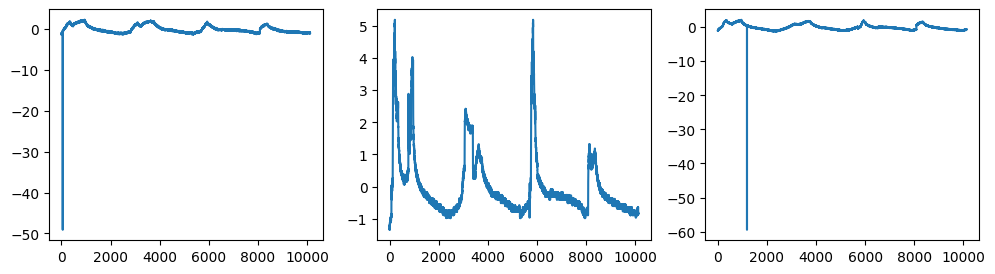

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 3))
plt.subplot(1,3,1)
project_df.S1Temp.plot()
plt.subplot(1,3,2)
project_df.S2Temp.plot(ax=plt.gca())
plt.subplot(1,3,3)
project_df.S3Temp.plot(ax=plt.gca())
plt.show()

# Light

/tmp/ipykernel_354021/955311149.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)
/tmp/ipykernel_354021/955311149.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,2)


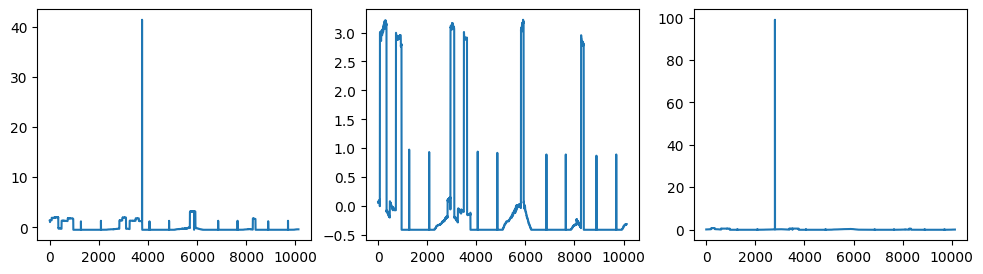

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 3))
plt.subplot(1,3,1)
project_df.S1Light.plot()
plt.subplot(1,3,2)
project_df.S2Light.plot(ax=plt.gca())
plt.subplot(1,3,3)
project_df.S3Light.plot(ax=plt.gca())
plt.show()

# CO2

<AxesSubplot: >

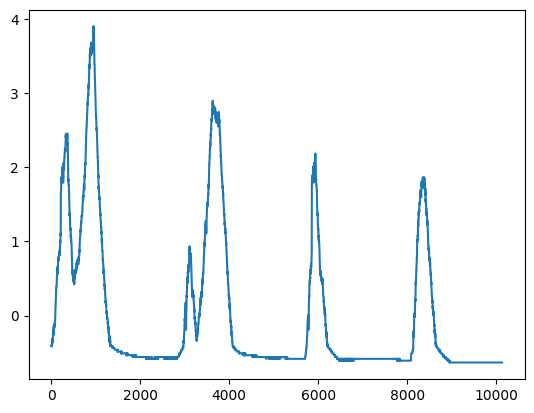

In [6]:
project_df['CO2'].plot()

# PIR

/tmp/ipykernel_354021/3791813093.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
/tmp/ipykernel_354021/3791813093.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)


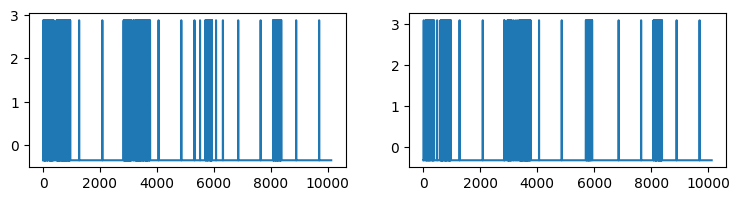

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9, 2))
plt.subplot(1,2,1)
project_df.PIR1.plot()
plt.subplot(1,2,2)
project_df.PIR2.plot(ax=plt.gca())
plt.show()

# Removing Basic Outliers

In [ ]:
def getOutliersFromAverage(data, gain):
    outliers = []

    for feature in data.columns:
        average = data[feature].mean()
        std = data[feature].std()

        outliers += (
            data[feature][data[feature] <= (average - std * gain)].index.tolist()
            + data[feature][data[feature] >= (average + std * gain)].index.tolist()
        )

    return list(dict.fromkeys(outliers))
  
def removeLine(data, indexes):
    return data.drop(indexes)

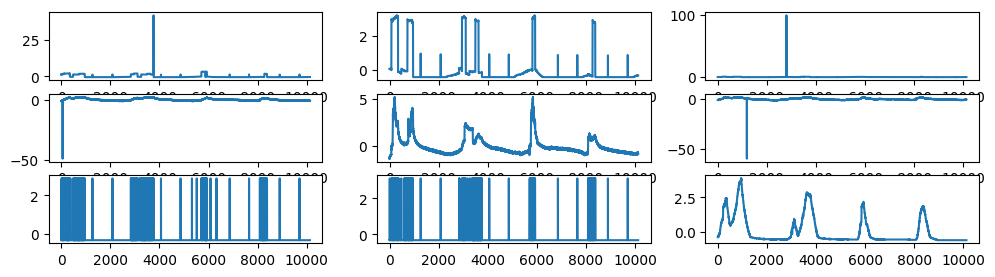

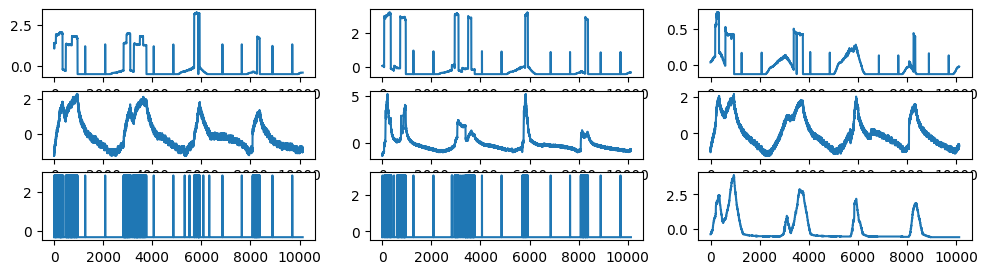

In [8]:
# FIGURE
fig, axs = plt.subplots(3, 3, figsize=(12, 3))
# LIGHT
plt.subplot(3,3,1)
project_df.S1Light.plot()
plt.subplot(3,3,2)
project_df.S2Light.plot(ax=plt.gca())
plt.subplot(3,3,3)
project_df.S3Light.plot(ax=plt.gca())
# TEMP
plt.subplot(3,3,4)
project_df.S1Temp.plot()
plt.subplot(3,3,5)
project_df.S2Temp.plot(ax=plt.gca())
plt.subplot(3,3,6)
project_df.S3Temp.plot(ax=plt.gca())
# PIR
plt.subplot(3,3,7)
project_df.PIR1.plot()
plt.subplot(3,3,8)
project_df.PIR2.plot(ax=plt.gca())
# CO2
plt.subplot(3,3,9)
project_df.CO2.plot(ax=plt.gca())
plt.show()

outliers = getOutliersFromAverage(project_df, 6)
new_project_df = removeLine(project_df, outliers)
new_output_df = removeLine(df_output, outliers)
new_dates_df = removeLine(df_dates, outliers)

# FIGURE
fig, axs = plt.subplots(3, 3, figsize=(12, 3))
# LIGHT
plt.subplot(3,3,1)
new_project_df.S1Light.plot()
plt.subplot(3,3,2)
new_project_df.S2Light.plot(ax=plt.gca())
plt.subplot(3,3,3)
new_project_df.S3Light.plot(ax=plt.gca())
# TEMP
plt.subplot(3,3,4)
new_project_df.S1Temp.plot()
plt.subplot(3,3,5)
new_project_df.S2Temp.plot(ax=plt.gca())
plt.subplot(3,3,6)
new_project_df.S3Temp.plot(ax=plt.gca())
# PIR
plt.subplot(3,3,7)
new_project_df.PIR1.plot()
plt.subplot(3,3,8)
new_project_df.PIR2.plot(ax=plt.gca())
# CO2
plt.subplot(3,3,9)
new_project_df.CO2.plot(ax=plt.gca())
plt.show()


# Analysis

In [9]:
def grid_search(clf_class, X_train, Y_train, X_test, Y_test):
    activations = ["relu", "tanh", "logistic"]
    hidden_layer_sizes = [(1), (18), (100)]
    random_states = [0, 2]
    max_iters = [100, 200]
    alphas = [0.0001, 0.01, 1]

    metrics = []
    combinations = []

    for act in activations:
        for hid in hidden_layer_sizes:
            for ran in random_states:
                for it in max_iters:
                    for al in alphas:
                        clf = clf_class(alpha=al, hidden_layer_sizes=hid, activation=act, random_state=ran, max_iter=it)

                        y_pred = clf.fit(X_train, Y_train).predict(X_test)

                        metrics.append(classification_report(Y_test, y_pred, output_dict=True))  # type: ignore
                        combinations.append(str(act) + "_" + str(hid) + "_" + str(ran) + "_" + str(it) + "_" + str(al))

    max_id = 0
    max_recall = 0

    for id, metric in enumerate(metrics):
        if metric["macro avg"]["recall"] > max_recall:
            max_id = id
            max_recall = metric["macro avg"]["recall"]

    act, hid, ran, it, al = combinations[max_id].split("_")

    return act, ast.literal_eval(hid), int(ran), int(it), float(al)


In [10]:
X = new_project_df.to_numpy()
Y = new_output_df.to_numpy()
Z = new_dates_df.to_numpy()

Nearest Neighbors

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1594
           1       1.00      0.98      0.99        92
           2       0.93      0.98      0.96       177
           3       0.98      0.91      0.95       162

    accuracy                           0.99      2025
   macro avg       0.98      0.97      0.97      2025
weighted avg       0.99      0.99      0.99      2025


Linear SVM

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1594
           1       0.97      0.97      0.97        92
           2       0.88      0.84      0.86       177
           3       0.83      0.80      0.81       162

    accuracy                           0.97      2025
   macro avg       0.92      0.90      0.91      2025
weighted avg       0.97      0.97      0.97      2025


RBF SVM

              precision    recall  f1-score   support

           0       1.00      1.00

/media/brunomcebola/Data/Faculdade/5º ano 1º trimestre/CInt/CInt-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Net

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1594
           1       1.00      0.97      0.98        92
           2       0.95      0.90      0.92       177
           3       0.87      0.89      0.88       162

    accuracy                           0.98      2025
   macro avg       0.95      0.94      0.94      2025
weighted avg       0.98      0.98      0.98      2025


Naive Bayes

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1594
           1       1.00      0.96      0.98        92
           2       0.84      0.70      0.76       177
           3       0.57      0.81      0.67       162

    accuracy                           0.93      2025
   macro avg       0.85      0.86      0.85      2025
weighted avg       0.95      0.93      0.94      2025




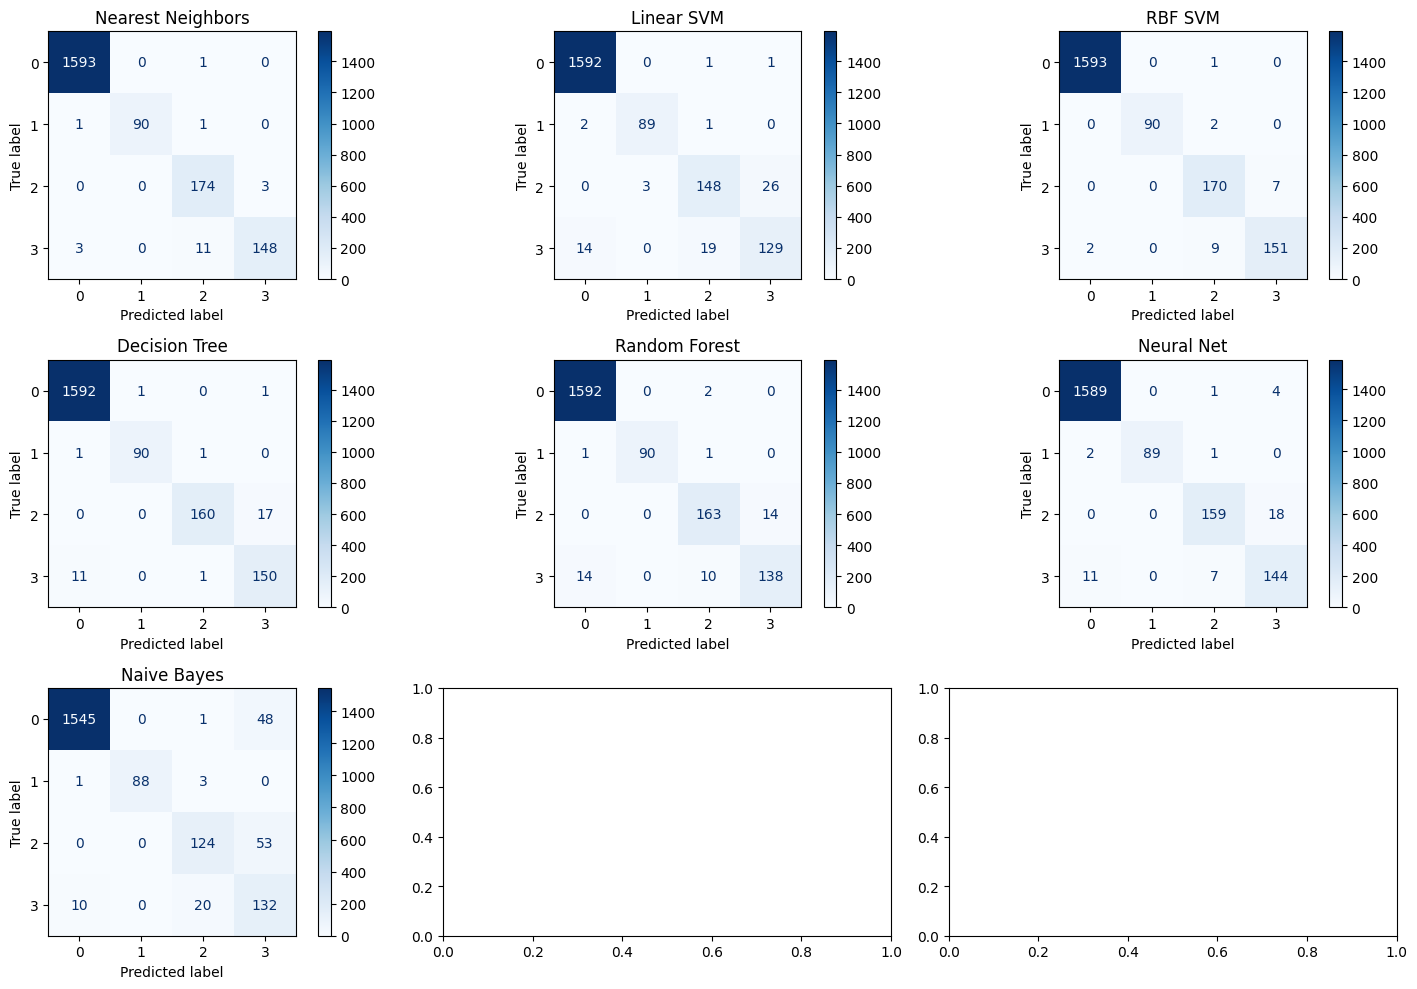

/media/brunomcebola/Data/Faculdade/5º ano 1º trimestre/CInt/CInt-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/brunomcebola/Data/Faculdade/5º ano 1º trimestre/CInt/CInt-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/brunomcebola/Data/Faculdade/5º ano 1º trimestre/CInt/CInt-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/brunomcebola/Data/Faculdade/5º ano 1º trimestre/CInt/CInt-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_percep

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1594
           1       1.00      0.97      0.98        92
           2       0.94      0.92      0.93       177
           3       0.89      0.88      0.88       162

    accuracy                           0.98      2025
   macro avg       0.95      0.94      0.95      2025
weighted avg       0.98      0.98      0.98      2025



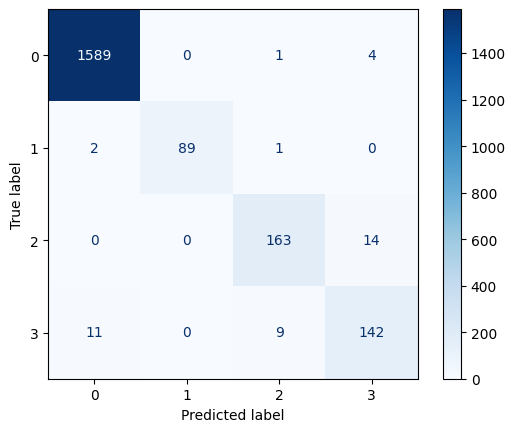

/media/brunomcebola/Data/Faculdade/5º ano 1º trimestre/CInt/CInt-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/brunomcebola/Data/Faculdade/5º ano 1º trimestre/CInt/CInt-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/brunomcebola/Data/Faculdade/5º ano 1º trimestre/CInt/CInt-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

relu 100 0 200 0.0001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1594
           1       1.00      1.00      1.00        92
           2       0.93      0.96      0.95       177
           3       0.96      0.93      0.94       162

    accuracy                           0.99      2025
   macro avg       0.97      0.97      0.97      2025
weighted avg       0.99      0.99      0.99      2025



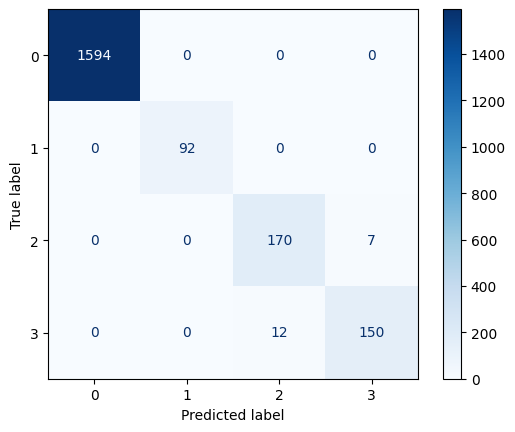

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# various classifiers

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "Naive Bayes"
]

classifiers = [
    KNeighborsClassifier(4),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),  # type: ignore
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),  # type: ignore
    MLPClassifier(alpha=1, max_iter=100),
    GaussianNB()
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

for name, clf, ax in zip(names, classifiers, axes.flatten()): # type: ignore
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=mpl.cm.Blues, ax=ax)
    
    ax.title.set_text(name)
    
    print(name)
    print()
    print(classification_report(y_test, y_pred))
    print()

plt.tight_layout()
plt.show()

# k-fold

kf = KFold(n_splits=10)
clf = MLPClassifier(alpha=1, max_iter=100)

for train_indices, test_indices in kf.split(X_train):
    clf.fit(X_train[train_indices], y_train[train_indices])
    
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))  # type: ignore

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=mpl.cm.Blues)
plt.show()

# grid search

act, hid, ran, it, al = grid_search(MLPClassifier, X_train, y_train, X_test, y_test)

clf = MLPClassifier(alpha=al, hidden_layer_sizes=hid, activation=act, random_state=ran, max_iter=it)

y_pred = clf.fit(X_train, y_train).predict(X_test)

print(act, hid, ran, it, al)
print(classification_report(y_test, y_pred))  # type: ignore

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=mpl.cm.Blues)
plt.show()
